In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Proste progowanie

Sprawa jest prosta. Jeśli wartość piksela jest większa niż wartość progowa, to przypisywana jest jedna wartość (może być biała), w przeciwnym razie przypisywana jest inna wartość (może być czarna). 

W tym celu używa się funkcji __cv2.threshold__. [dokumentacja](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57)
- Pierwszym argumentem jest obraz źródłowy, który powinien być obrazem w __skali szarości__. 
- Drugim argumentem jest wartość progowa, która służy do klasyfikacji wartości pikseli. 
- Trzeci argument to maxVal, który reprezentuje wartość, która ma być podana, jeśli wartość piksela jest większa (czasami mniejsza) od wartości progowej. 

OpenCV dostarcza różnych stylów progowania i decyduje o tym czwarty parametr funkcji. Różne typy są:
- cv2.THRESH_BINARY:   $dst(x,y) = \texttt{maxval} ~~~ if ~~\texttt{src}(x,y) ~~> \texttt{thresh} else ~~{0}$
- cv2.THRESH_BINARY_INV: Odwrotność binarnej
- cv2.THRESH_TRUNC: $dst(x,y) = \texttt{thresh} ~~~ if ~~\texttt{src}(x,y) ~~> \texttt{thresh} else  ~~\texttt{src}(x,y)$
- cv2.THRESH_TOZERO: $dst(x,y) = \texttt{src}(x,y) ~~~ if ~~\texttt{src}(x,y) ~~> \texttt{thresh} else  ~~0$
- cv2.THRESH_TOZERO_INV: Odwrotność TOZERO



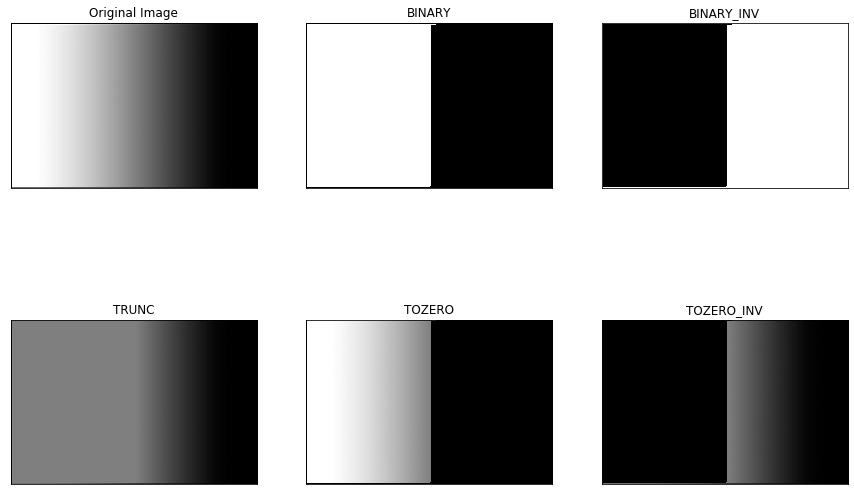

In [16]:
plt.rcParams['figure.figsize'] = [15, 10]

image = cv2.imread('agh_cv/gradient.png')

ret, thresh1 = cv2.threshold(image, thresh=127, maxval=255, type=cv2.THRESH_BINARY)
ret, thresh2 = cv2.threshold(image, thresh=127, maxval=255, type=cv2.THRESH_BINARY_INV)
ret, thresh3 = cv2.threshold(image, thresh=127, maxval=255, type=cv2.THRESH_TRUNC)
ret, thresh4 = cv2.threshold(image, thresh=127, maxval=255, type=cv2.THRESH_TOZERO)
ret, thresh5 = cv2.threshold(image, thresh=127, maxval=255, type=cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [image, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(6):
    plt.subplot(2,3,i+1), plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

### Progowanie Adaptacyjne
W poprzedniej sekcji wykorzystaliśmy wartość globalną jako wartość progową. Ale może to nie być dobre we wszystkich warunkach, w których obraz ma różne warunki oświetleniowe w różnych obszarach. W takim przypadku wybieramy próg adaptacyjny. Wówczas algorytm oblicza próg dla małych obszarów obrazu. Otrzymujemy więc różne progi dla różnych regionów tego samego obrazu i daje nam to lepsze wyniki dla obrazów o różnym naświetleniu. Metoda adaptacyjna - decyduje o sposobie obliczania wartości progowej.

Ma trzy „specjalne” parametry wejściowe: [dokumentacja](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#ga72b913f352e4a1b1b397736707afcde3)

- __cv2.ADAPTIVE_THRESH_MEAN_C__: wartość progowa jest średnią obszaru sąsiedztwa lub __cv2.ADAPTIVE_THRESH_GAUSSIAN_C__: wartość progowa to ważona suma wartości sąsiedztwa, w których wagi są określone rozkładem gaussowskim.
- __Rozmiar bloku__ - decyduje o wielkości obszaru sąsiedztwa.
- __C__ - To tylko stała odejmowana od obliczonej średniej lub średniej ważonej.

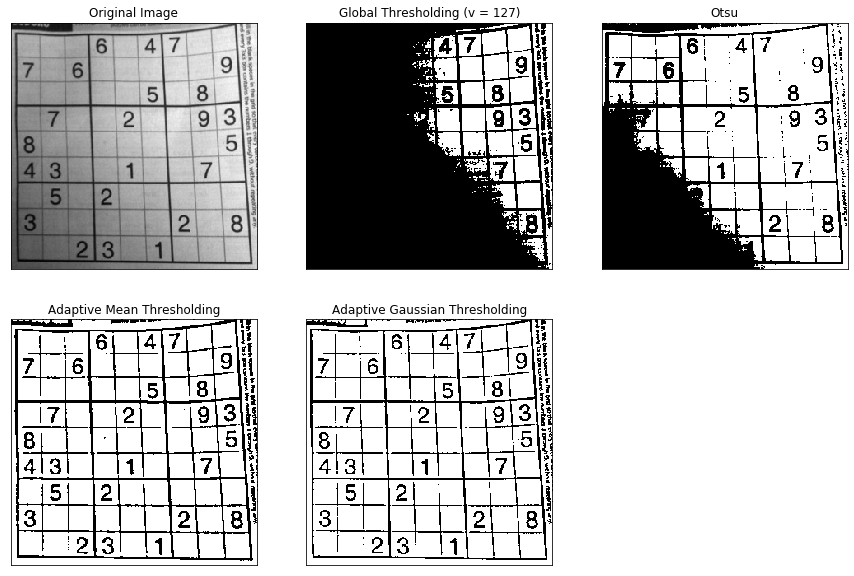

In [18]:
image = cv2.imread('agh_cv/sudoku_threshold.png', 1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# punkty do przekształcenia perspektywy
pts1 = np.float32([[50, 50], [400, 50], [15, 400], [400, 400]])
pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])

# przekształcenie perspektywy
transformation_matrix = cv2.getPerspectiveTransform(pts1,pts2)
image = cv2.warpPerspective(image, transformation_matrix, (300,300))

# progowanie binarne
ret, th1 = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# progowanie adaptacyjne maxValue, adaptiveMethod, thresholdType, blockSize, C
th2 = cv2.adaptiveThreshold(image,
                            maxValue=255,
                            adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
                            thresholdType=cv2.THRESH_BINARY,
                            blockSize=13,
                            C=8)
th3 = cv2.adaptiveThreshold(image,
                            maxValue=255,
                            adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            thresholdType=cv2.THRESH_BINARY,
                            blockSize=13,
                            C=8)
ret, otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# plt.imshow(th3, cmap='gray')


titles = ['Original Image', 'Global Thresholding (v = 127)', 'Otsu',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [image, th1, otsu, th2, th3]

for i in range(5):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

## Przykład książka w złym świetle

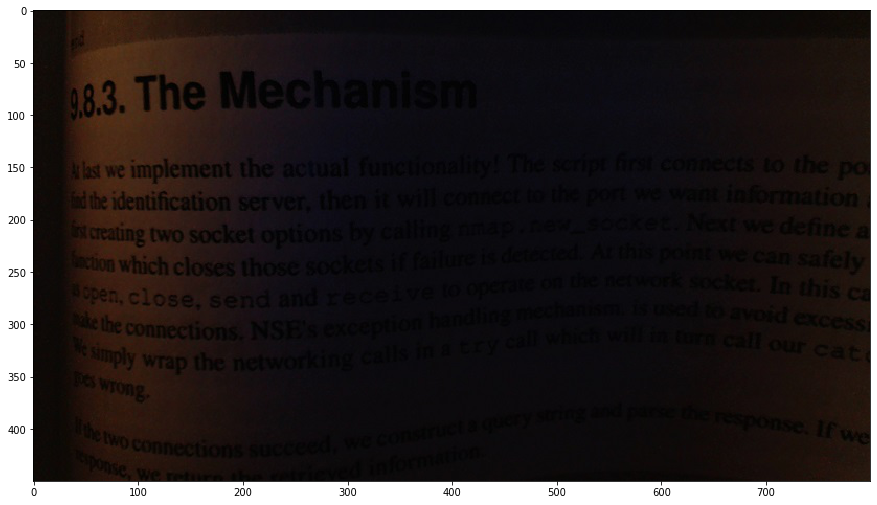

In [10]:
image = cv2.imread('agh_cv/book_threshold.png')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

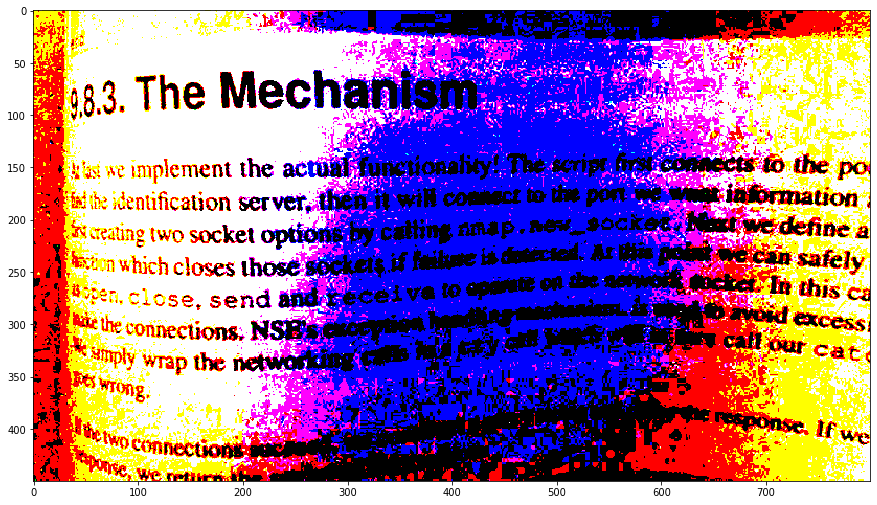

In [11]:
ret, threshold = cv2.threshold(image, 12, 255, cv2.THRESH_BINARY)
plt.imshow(cv2.cvtColor(threshold, cv2.COLOR_BGR2RGB))

Obraz jest teraz nieco lepszy do czytania, ale nadal nie jest to dobra jakość. Wizualnie jest lepiej, ale wykorzystanie programu do analizy tego będzie nadal dość trudne. Zobaczmy, czy uda nam się to jeszcze bardziej polepszyć. Najpierw przeskalujmy obrazek w skali szarości, a następnie zróbmy progowanie.

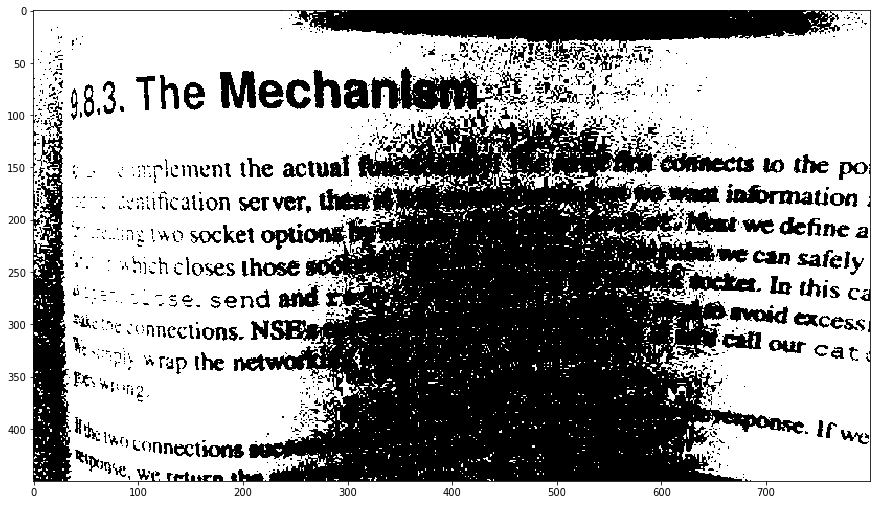

In [12]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, threshold = cv2.threshold(gray, 11, 255, cv2.THRESH_BINARY)
plt.imshow(threshold, cmap='gray')

Nie jest to najlepszy wynik, spróbujmy progowania adaptacyjnego jak w przykładzie z sudoku.

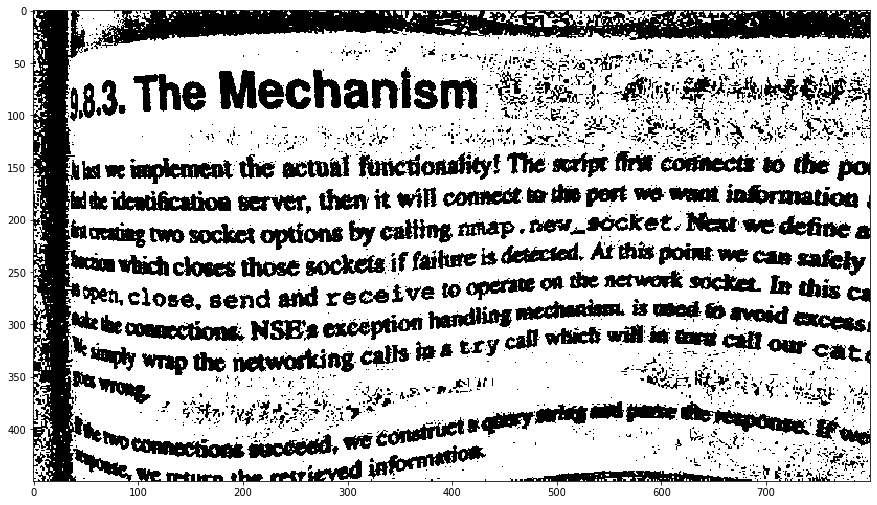

In [13]:
threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
plt.imshow(threshold, cmap='gray')

## Zadanie

Wypróbuj poznane metody progowania na zdjęciach zapisanych w plikach kolejno:
- 'agh_cv/task_thresholding1.png'
- 'agh_cv/task_thresholding2.png'
- 'agh_cv/task_thresholding3.png'

In [29]:
from ipywidgets import interact

image = cv2.imread('agh_cv/task_thresholding1.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def thresh(threshold):
    plt.imshow(cv2.threshold(gray, thresh=threshold, maxval=255, type=cv2.THRESH_BINARY)[1], cmap='gray')
    
interact(thresh, threshold=range(0, 256))

interactive(children=(Dropdown(description='threshold', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

<function __main__.thresh(threshold)>

In [32]:
from ipywidgets import interact

image = cv2.imread('agh_cv/task_thresholding1.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def thresh_adaptive(blockSize, C):
    plt.imshow(cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C),
               cmap='gray')
    
interact(thresh_adaptive, blockSize=range(3, 500, 2), C=range(0, 256))

interactive(children=(Dropdown(description='blockSize', options=(3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 2…

<function __main__.thresh_adaptive(blockSize, C)>

In [33]:
from ipywidgets import interact

image = cv2.imread('agh_cv/task_thresholding2.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def thresh(threshold):
    plt.imshow(cv2.threshold(gray, thresh=threshold, maxval=255, type=cv2.THRESH_BINARY)[1], cmap='gray')
    
interact(thresh, threshold=range(0, 256))

interactive(children=(Dropdown(description='threshold', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

<function __main__.thresh(threshold)>

In [35]:
from ipywidgets import interact

image = cv2.imread('agh_cv/task_thresholding2.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def thresh_adaptive(blockSize, C):
    plt.imshow(cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C),
               cmap='gray')
    
interact(thresh_adaptive, blockSize=range(3, 500, 2), C=range(0, 256))

interactive(children=(Dropdown(description='blockSize', options=(3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 2…

<function __main__.thresh_adaptive(blockSize, C)>

In [36]:
from ipywidgets import interact

image = cv2.imread('agh_cv/task_thresholding3.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def thresh(threshold):
    plt.imshow(cv2.threshold(gray, thresh=threshold, maxval=255, type=cv2.THRESH_BINARY)[1], cmap='gray')
    
interact(thresh, threshold=range(0, 256))

interactive(children=(Dropdown(description='threshold', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

<function __main__.thresh(threshold)>

In [38]:
from ipywidgets import interact

image = cv2.imread('agh_cv/task_thresholding3.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def thresh_adaptive(blockSize, C):
    plt.imshow(cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C),
               cmap='gray')
    
interact(thresh_adaptive, blockSize=range(3, 500, 2), C=range(0, 256))

interactive(children=(Dropdown(description='blockSize', options=(3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 2…

<function __main__.thresh_adaptive(blockSize, C)>